# OpenFOAM PMDI validation - droplet size

This program plots the time-average, conditionally spatially-averaged d32 distribution exported from Paraview.
It compares this to Malvern data provided by Roger collected at Woolcock.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 21/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [117]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import scipy.integrate
%matplotlib notebook

In [81]:
# Get the Malvern data
Malv = {}
dt = ['|S10']
for i in range(40): dt.append('<f8')
    
for f in glob.glob("/Users/dduke/Desktop/PMDI-papers-data/Validation/d32/malvern*.csv"):
    name = os.path.splitext(os.path.basename(f))[0]
    Malv[name] = np.genfromtxt(f,delimiter=',',dtype=dt)

In [82]:
# Convert the mixed array into bin sizes and Cycle PDFs
means={}
stds={}
sizes={}

for k in Malv.keys():
    M=Malv[k]
    size_micron = np.array(M[0].tolist()[1:])
    cycles=[]
    for i in range(1,len(M)):
        if b'Cycle' in M[i][0]:
            cycles.append(M[i].tolist()[1:])
    pdf_array = np.vstack(cycles)

    means[k]=np.nanmean(pdf_array,axis=0)
    stds[k]=np.nanstd(pdf_array,axis=0)
    sizes[k]=size_micron    

<IPython.core.display.Javascript object>


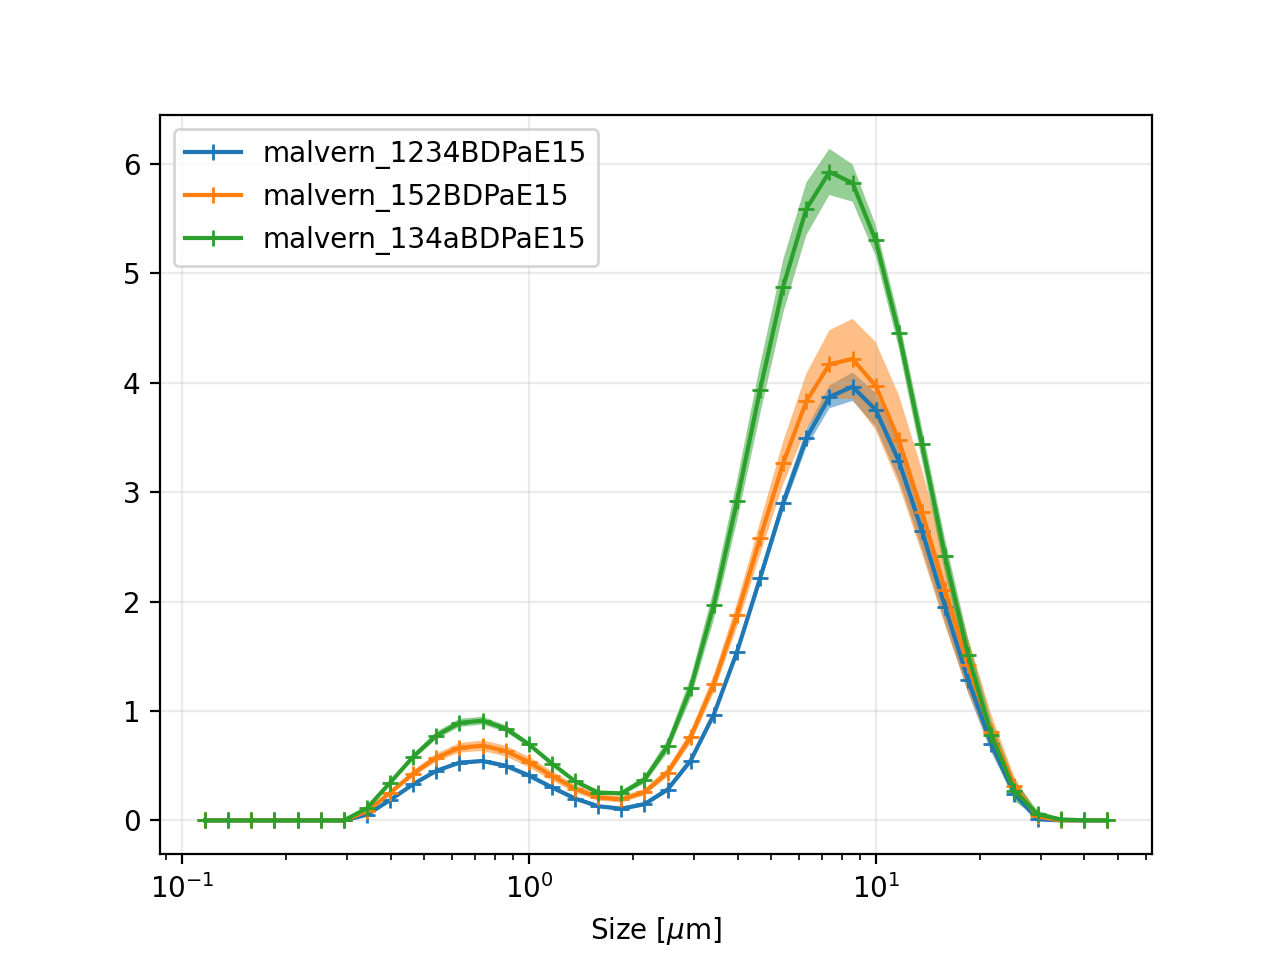

In [96]:
# Plot the Malvern data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
ax.set_xscale('log')
for k in means.keys():
    ax.plot(sizes[k],means[k],label=k,marker='+')
    ax.fill_between(sizes[k],means[k]-stds[k],means[k]+stds[k],alpha=0.5)

plt.xlabel("Size [$\mu$m]")
plt.legend();

In [92]:
# Get the OpenFOAM data
OF={}
for f in glob.glob("/Users/dduke/Desktop/PMDI-papers-data/Validation/d32/*d32new.csv"):
    name = os.path.splitext(os.path.basename(f))[0].split('_')[0]    
    OF[name]=np.genfromtxt(f,delimiter=',',skip_header=1)

<IPython.core.display.Javascript object>


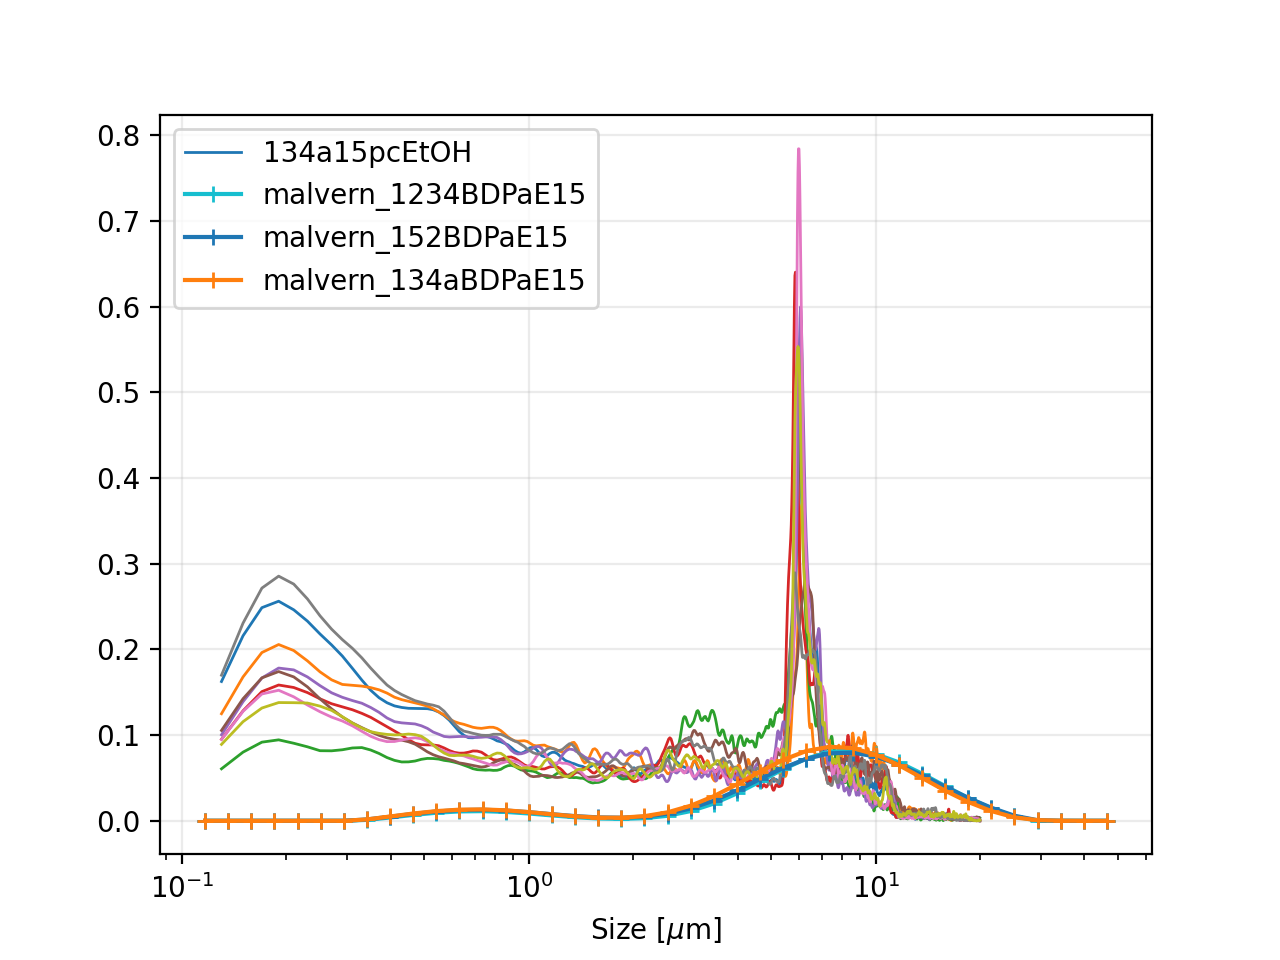

In [122]:
# Plot the OpenFOAM data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
ax.set_xscale('log')
kern=np.hamming(10)
kern/=np.sum(kern)

for p in OF.keys():
  if '134a15pc' in p:
    l=p
    st = np.where(OF[p][:,0] >= size_micron.min())[0][0]
    sz = OF[p][st:-1,0]
    
    for n in range(1,OF[p].shape[1]):
        
        pdf=OF[p][st:-1,n]
        pdf /= scipy.integrate.simps(pdf,x=sz)
        
        pdf = np.convolve(pdf, kern, 'same')
        
        ax.plot(sz, pdf, lw=1, label=l)
        l=None

for k in means.keys():
    integral=scipy.integrate.simps(means[k],x=sizes[k])
    ax.plot(sizes[k],means[k]/integral,label=k,marker='+')
    #ax.fill_between(sizes[k],means[k]-stds[k],means[k]+stds[k],alpha=0.5)        
        
plt.xlabel("Size [$\mu$m]")
plt.legend();